In [1]:
from metadensity.truncation import *
from metadensity.sequence import *
import matplotlib.pyplot as plt
from collections import Counter
import sys
sys.path.append('/home/hsher/Metadensity/scripts/')
from dataloader import *
from shapeloader import *

In [2]:
# crosslinking to bigwigs
help(strand_specific_pileup)

Help on function strand_specific_pileup in module metadensity.truncation:

strand_specific_pileup(bam_fileobj, interval=None, chrom=None, start=None, end=None, strand=None, single_end=False)
    pileup reads of a defined region, 
    return profile (pd.DataFrame), count of truncation, deletion and nucleotides, index = genomic positions



In [3]:
def get_datapointer_from_full_prefix(prefix, uid, RBP, Cell_line):
    ''' given prefix in a dataframe, return another dataframe with full path'''
    datapointer = pd.Series()
    datapointer['uid'] = uid
    datapointer['RBP'] = RBP
    datapointer['Cell line'] = Cell_line
    
    
    datapointer['bam_0'] = prefix+'_CLIP1_CLIP.umi.r1.fq.genome-mappedSoSo.rmDupSo.bam'
    datapointer['bam_1'] = prefix+'_CLIP2_CLIP.umi.r1.fq.genome-mappedSoSo.rmDupSo.bam'
    datapointer['bam_control_0'] = prefix+'_CLIP1_INPUT.umi.r1.fq.genome-mappedSoSo.rmDupSo.bam'
    datapointer['bam_control_1'] = prefix+'_CLIP2_INPUT.umi.r1.fq.genome-mappedSoSo.rmDupSo.bam'
    
    # biuild bigwig filename
    datapointer['plus_0'] = prefix + '_CLIP1_CLIP.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.pos.bw'
    datapointer['plus_1'] = prefix + '_CLIP2_CLIP.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.pos.bw'
    datapointer['plus_control_0'] = prefix + '_CLIP1_INPUT.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.pos.bw'
    datapointer['plus_control_1'] = prefix + '_CLIP2_INPUT.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.pos.bw'
    datapointer['minus_0'] = prefix + '_CLIP1_CLIP.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.neg.bw'
    datapointer['minus_1'] = prefix + '_CLIP2_CLIP.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.neg.bw'
    datapointer['minus_control_0'] = prefix + '_CLIP1_INPUT.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.neg.bw'
    datapointer['minus_control_1'] = prefix + '_CLIP2_INPUT.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.neg.bw'
    
    # build individual peak file name
    datapointer['bed_0'] = prefix + '_CLIP1_CLIP.umi.r1.fq.genome-mappedSoSo.rmDupSo.peakClusters.normed.compressed.sorted.blacklist-removed.bed'
    datapointer['bed_1'] = prefix + '_CLIP2_CLIP.umi.r1.fq.genome-mappedSoSo.rmDupSo.peakClusters.normed.compressed.sorted.blacklist-removed.bed'
    
    # IDR
    # build IDR peak path
    #idr_base = '/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results_20210303/'
    #datapointer['idr']=idr_base + 'encore_master_'+ datapointer['Batch'] + '_IDR/results/' + datapointer['uid'] + '_CLIP1_rep1.vs.' + datapointer['uid'] + '_CLIP2_rep2.bed'
    
    return datapointer

In [4]:
adar_prefix = '/projects/ps-yeolab5/encore/processing/batch23_20210302/results/encode4_batch23.4137'
datapointer = get_datapointer_from_full_prefix(adar_prefix, '4137', 'ADAR', 'K562')



/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


# Here I read the bam files (Aligned reads from ADAR eCLIP) 

In [5]:
bam1 = pysam.AlignmentFile(datapointer['bam_0'])
bam2 = pysam.AlignmentFile(datapointer['bam_1'])
bamin1 = pysam.AlignmentFile(datapointer['bam_control_0'])
bamin2 = pysam.AlignmentFile(datapointer['bam_control_1'])

# Here I get the peaks (regions with many eCLIP reads)
I filter for peaks that has a low p-value, high fold change, and is common between 2 biological replicates

In [7]:
# filter for log2 fold change and -log10 p-val
peak1 = BedTool(datapointer['bed_0']).filter(lambda peak: float(peak[3]) > 3 and float(peak[4]) > 3)
peak2 = BedTool(datapointer['bed_1']).filter(lambda peak: float(peak[3]) > 3 and float(peak[4]) > 3)

common_peak = peak1.intersect(peak2, s = True, u = True).saveas()

In [8]:
len(common_peak) # we have this many

2992

# Here I load the SHAPE bigwig file

In [9]:
import pyBigWig
icshape_plus = pyBigWig.open('/home/hsher/icshape_data_zhang/icSHAPE/K562-plus.bw')
icshape_minus = pyBigWig.open('/home/hsher/icshape_data_zhang/icSHAPE/K562-minus.bw')

# This function integrates all information we want
1. First it finds truncation (5' read start), mismatch and indel in eCLIP reads. These are all signals of crosslinking. It also characterize what type of mismatch it is (whether U->C or U->G, for example).
2. Then it fetches the shape data
3. finally it gets the reference sequence
4. last but not least, join them

In [10]:
# fetch eclip mismatch, trunction and indel. These are indication of a crosslinking (truncation is the most likely event)
def align_eclip_and_shape(p, bam1 = bam1, bam2 = bam2, bamin1 = bamin1, bamin2 = bamin2):
    ''' fetch eCLIP crosslinking events for IP/INPUT for BedTool interval p
    Also fetch icSHAPE reacticity for the same region p
    join them together as a dataframe
    '''
    all_prof = []
    # get the eclip stuffs, the read is reverse complement to the reference
    for eclip_bam, name in zip([bam1, bam2, bamin1, bamin2], ['IP1', 'IP2', 'IN1', 'IN2']):
        eclip_profile = strand_specific_pileup(eclip_bam, chrom = p.chrom, start = p.start, end = p.end, strand = p.strand)
        eclip_profile.columns = [c+'_'+name for c in eclip_profile.columns]
        all_prof.append(eclip_profile)
    
    # join the 2 reps and the inputs together
    eclip_profile = pd.concat(all_prof, axis = 1)

    if p.strand == '+':
        reactivity=icshape_plus.values(p.chrom, p.start, p.end)
    else:
        reactivity=icshape_minus.values(p.chrom, p.start, p.end)
    
    # organize into series
    react_col = pd.Series(reactivity, index=np.arange(p.start, p.end))

    # put into the same dataframe
    eclip_profile['shape'] = react_col
    
    # fetch reference genome sequence
    seq = getRNAsequence(p)
    pos = np.arange(p.start, p.end)
    if p.strand == '-':
        pos = pos[::-1]
    
    eclip_profile['ref_seq'] = pd.Series(seq, index = pos)
    
    return eclip_profile
    

# I prepare the files for all the peaks with shape data
- The peaks can been seen as a ADAR binding sites for now. Then agya can give us a better set.
- most peaks don't have shape data (all NULL) so I did not include those
- for now we have about 50 of them.

In [11]:

for n, p in enumerate(common_peak):
    df = align_eclip_and_shape(p)
    if df['shape'].count()>0: # if there is shape data
        df.to_csv('eclip_peak_shape_tsv/peak_{}_{}_{}_{}.csv'.format(p.chrom, p.start, p.end, p.strand))
        print(n)

31
32
461
462
524
525
590
668
669
670
671
689
690
1011
1012
1013
1028
1029
1030
1132
1265
1266
1267
1268
1269
1363
1364
1753
1927
1928
2053
2131
2371
2372
2373
2545
2546
2547
2548
2683
2694
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2987


# A short visualization test

Using:  /home/hsher/gencode_coords/gencode.v33.transcript.gff3


Text(0.5, 0.98, 'eCLIP df (IP) and SHAPE')

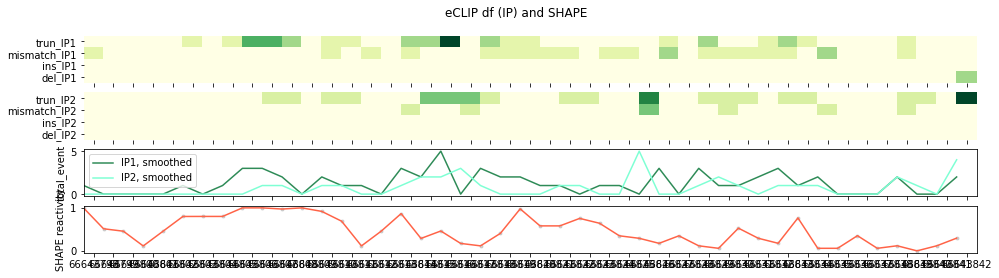

In [12]:
import seaborn as sns
from metadensity.metadensity import *
# exon only

# This is the aligned data in region chr11, 66643798 66643843 plus strand
# it is already a peak that is in both replicate, with p<10**-3 and fold change > 8 (over the input)
df = pd.read_csv('eclip_peak_shape_tsv/peak_chr11_66643798_66643843_+.csv', index_col = 0, header = 0)

f, ax = plt.subplots(4,1, figsize = (16,4), sharex = True)

eclip_event_cols = ['trun_IP1', 'mismatch_IP1', 'ins_IP1', 'del_IP1']
eclip_event_cols2 = ['trun_IP2', 'mismatch_IP2', 'ins_IP2', 'del_IP2']

ip1_events = df[eclip_event_cols].sum(axis = 1)
ip2_events = df[eclip_event_cols2].sum(axis = 1)
ax[2].plot(ip1_events.values, label = 'IP1, smoothed', color = 'seagreen')
ax[2].plot(ip2_events.values, label = 'IP2, smoothed', color = 'aquamarine')
ax[2].set_ylabel('total_event')
ax[2].legend()

shape_val = df['shape']
ax[3].scatter(np.arange(df.shape[0]), shape_val, color = 'grey', marker = '.', alpha = 0.3)
ax[3].plot(shape_val.values, color = 'tomato')
ax[3].set_ylabel('SHAPE reactivity')


sns.heatmap(df[eclip_event_cols].T, ax = ax[0], cmap = 'YlGn', yticklabels = 1, cbar = False)
sns.heatmap(df[eclip_event_cols2].T, ax = ax[1], cmap = 'YlGn', yticklabels = 1, cbar = False)

plt.suptitle('eCLIP df (IP) and SHAPE')

Text(0.5, 0.98, 'eCLIP df (IP) and SHAPE')

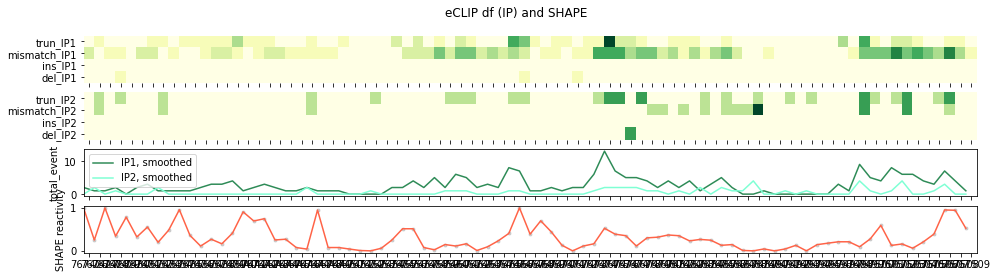

In [13]:
import seaborn as sns
from metadensity.metadensity import *
# exon only

# This is the aligned data in region chr11, 66643798 66643843 plus strand
# it is already a peak that is in both replicate, with p<10**-3 and fold change > 8 (over the input)
df = pd.read_csv('eclip_peak_shape_tsv/peak_chr11_767426_767510_-.csv', index_col = 0, header = 0)

f, ax = plt.subplots(4,1, figsize = (16,4), sharex = True)

eclip_event_cols = ['trun_IP1', 'mismatch_IP1', 'ins_IP1', 'del_IP1']
eclip_event_cols2 = ['trun_IP2', 'mismatch_IP2', 'ins_IP2', 'del_IP2']

ip1_events = df[eclip_event_cols].sum(axis = 1)
ip2_events = df[eclip_event_cols2].sum(axis = 1)
ax[2].plot(ip1_events.values, label = 'IP1, smoothed', color = 'seagreen')
ax[2].plot(ip2_events.values, label = 'IP2, smoothed', color = 'aquamarine')
ax[2].set_ylabel('total_event')
ax[2].legend()

shape_val = df['shape']
ax[3].scatter(np.arange(df.shape[0]), shape_val, color = 'grey', marker = '.', alpha = 0.3)
ax[3].plot(shape_val.values, color = 'tomato')
ax[3].set_ylabel('SHAPE reactivity')


sns.heatmap(df[eclip_event_cols].T, ax = ax[0], cmap = 'YlGn', yticklabels = 1, cbar = False)
sns.heatmap(df[eclip_event_cols2].T, ax = ax[1], cmap = 'YlGn', yticklabels = 1, cbar = False)

plt.suptitle('eCLIP df (IP) and SHAPE')

# Explaining what each csv contain

In [19]:
df.head() # the index are genomic position, the start,end,strand,chrom is in the filename

,A_IP1,T_IP1,C_IP1,G_IP1,trun_IP1,del_IP1,ins_IP1,mismatch_IP1,A_IP2,T_IP2,...,A_IN2,T_IN2,C_IN2,G_IN2,trun_IN2,del_IN2,ins_IN2,mismatch_IN2,shape,ref_seq
767426,0.0,2.0,0.0,34.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.989,C
767427,0.0,0.0,36.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.252,G
767428,34.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000,U
767429,1.0,0.0,35.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.341,G
767430,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.784,C


In [18]:
df.iloc[0]
# let us look at 1 row (1 nucleotide)
# _IP1 is for Immunoprecipitation, rep1/ _IP2
# _IN1/IN2 are the input library. This is for background normalization (crosslinking bias, RNA expression level...). For the first pass ignore them

# trun_{}: how many read trunction happen here
# del: deletion
# ins: insertion
# mismatch: mismatch
# the above 4 are all signals of crosslinking (RBP nearby)

# A/T/C/G are the sequence on the read, it is complementary to the reference genome mostly, except for a few errors
# I'll explain below why we may want this

# ref_seq: reference genome sequence
# shape: icSHAPE reactivity

A_IP1               0
T_IP1               2
C_IP1               0
G_IP1              34
trun_IP1            0
del_IP1             0
ins_IP1             0
mismatch_IP1        2
A_IP2               0
T_IP2               0
C_IP2               0
G_IP2              13
trun_IP2            0
del_IP2             0
ins_IP2             0
mismatch_IP2        0
A_IN1               0
T_IN1               0
C_IN1               0
G_IN1               1
trun_IN1            0
del_IN1             0
ins_IN1             0
mismatch_IN1        0
A_IN2               0
T_IN2               0
C_IN2               0
G_IN2               3
trun_IN2            0
del_IN2             0
ins_IN2             0
mismatch_IN2        0
shape           0.989
ref_seq             C
Name: 767426, dtype: object

In [14]:
df.columns 
# eCLIP crosslinking sites (where RBP is crosslinked to RNA) causes trouble to the reverse transcription(RT) enzyme
# when the RT cannot pass, the read stop there, and we call this "read truncation"
# sometimes the RT squeezes it through, but it will make a mistake (either mismatch or indel)


# Thus to find where is the crosslink site, 3 types of event we need find in sequencing data: 
# truncation, mismatch and deletion
# Most events are truncation (about 70%)
# The rest are usually mismatches 30%.

# since ADAR's A to I editing might also introduce a mismatch, I also document the "type of mismatch in the columns"
# the columns 'A_IP1', 'T_IP1', 'C_IP1', 'G_IP1' means the nucleotide on the reads(cDNA), it is reverse complement to the reference genome
# by looking at these columns, you know what type of mismatch it is.

Index(['A_IP1', 'T_IP1', 'C_IP1', 'G_IP1', 'trun_IP1', 'del_IP1', 'ins_IP1',
       'mismatch_IP1', 'A_IP2', 'T_IP2', 'C_IP2', 'G_IP2', 'trun_IP2',
       'del_IP2', 'ins_IP2', 'mismatch_IP2', 'A_IN1', 'T_IN1', 'C_IN1',
       'G_IN1', 'trun_IN1', 'del_IN1', 'ins_IN1', 'mismatch_IN1', 'A_IN2',
       'T_IN2', 'C_IN2', 'G_IN2', 'trun_IN2', 'del_IN2', 'ins_IN2',
       'mismatch_IN2', 'shape', 'ref_seq'],
      dtype='object')

In [15]:
df[['A_IP1', 'T_IP1', 'C_IP1', 'G_IP1', 'ref_seq']]
# for example, position 767427 has 34 reads reading an A, 1 read reading as a T
# the "read sequence is reverse complement to the reference sequence"
# therefore in this position 2 read mistakenly sequenced as A(T_IP1), the rest are correctly sequenced (G_IP1)

# another example 767505, ref_seq = U
# 2 read misread as A(T_IP1); 2 read misread as G(C_IP1)
# using this can help us characterize what type of mismatch it is

,A_IP1,T_IP1,C_IP1,G_IP1,ref_seq
767426,0.0,2.0,0.0,34.0,C
767427,0.0,0.0,36.0,0.0,G
767428,34.0,1.0,0.0,0.0,U
767429,1.0,0.0,35.0,0.0,G
767430,0.0,0.0,0.0,35.0,C
...,...,...,...,...,...
767505,35.0,2.0,2.0,0.0,U
767506,1.0,1.0,36.0,1.0,G
767507,2.0,34.0,3.0,1.0,A
767508,1.0,36.0,2.0,0.0,A


In [16]:
df.loc[df['ref_seq']=='A', ['A_IP1', 'T_IP1', 'C_IP1', 'G_IP1', 'mismatch_IP1']] 
# since we are looking for A-->I editing
# I only list the regions where ref sequence is A
# ACCORDING to this paper, position with an "I" will have a A->G conversion
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0044184
# seems like some of the reads have A->G conversion (767465, 767507, 767508)
# can this also be a piece of evidence where ADAR is nearby?

,A_IP1,T_IP1,C_IP1,G_IP1,mismatch_IP1
767435,0.0,40.0,0.0,0.0,0.0
767442,1.0,47.0,0.0,0.0,1.0
767455,0.0,57.0,0.0,0.0,0.0
767465,0.0,53.0,2.0,0.0,2.0
767480,0.0,39.0,1.0,1.0,2.0
767482,0.0,43.0,0.0,1.0,1.0
767484,1.0,42.0,0.0,0.0,1.0
767496,0.0,46.0,0.0,0.0,0.0
767507,2.0,34.0,3.0,1.0,6.0
767508,1.0,36.0,2.0,0.0,3.0
